In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

In [72]:
target = 'Close'
Stock = pd.read_csv('/kaggle/input/apple-stock-price-from-19802021/AAPL.csv')

df_Stock = Stock
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})
df_Stock['Date'] = pd.to_datetime(df_Stock['Date'])
start_date = pd.Timestamp('2004-12-31')
df_Stock = df_Stock[df_Stock['Date'] > start_date]
df_Stock.set_index('Date', drop=True, inplace=True)
df_Stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-03,1.156786,1.162679,1.117857,1.130179,0.966323,691992000
2005-01-04,1.139107,1.169107,1.124464,1.141786,0.976247,1096810400
2005-01-05,1.151071,1.165179,1.143750,1.151786,0.984798,680433600
2005-01-06,1.154821,1.159107,1.130893,1.152679,0.985561,705555200
2005-01-07,1.160714,1.243393,1.156250,1.236607,1.057321,2227450400


In [73]:
df_Stock.shape

(4396, 6)

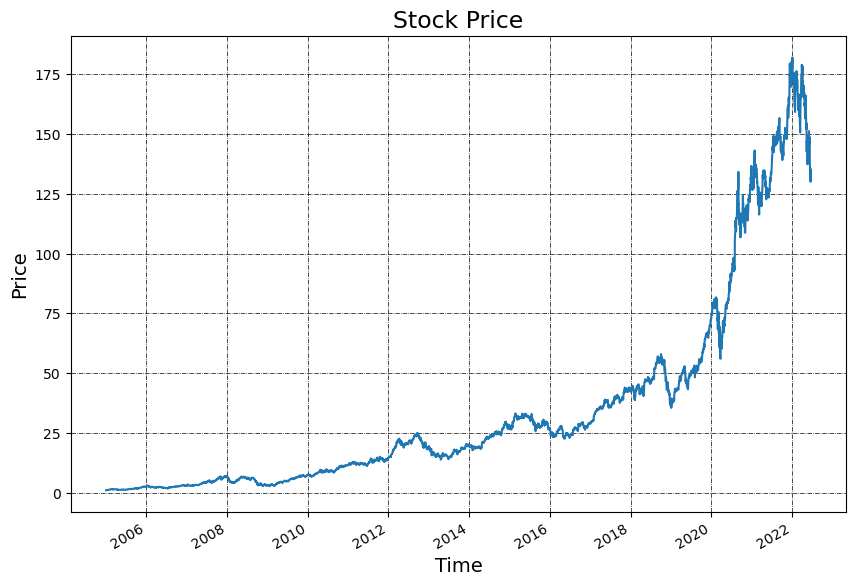

In [74]:
df_Stock[target].plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

**LSTM Prediction**

In [75]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math 
import os.path
import keras
from tensorflow.keras.models import model_from_json

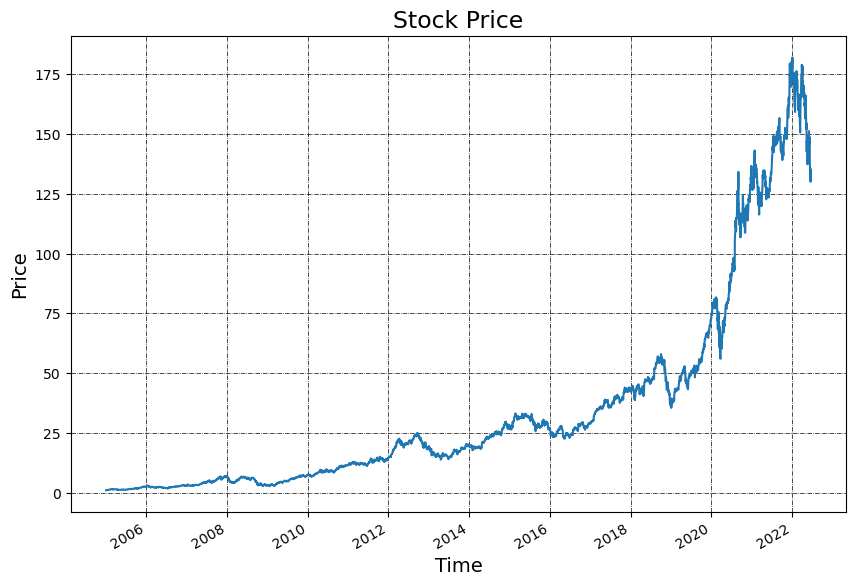

In [77]:
# make timeseries stationary
df = df_Stock
target_prices = df[target]
# plot series
target_prices.plot(figsize=(10, 7))
plt.title("Stock Price", fontsize=17)
plt.ylabel('Price', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [78]:
window = 20 # day window
train_perc, val_perc, test_perc = 0.88, 0.1, 0.02

values = target_prices.values
training_data_len = math.ceil(len(values)* train_perc)
validation_data_len = math.ceil(len(values)* val_perc)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

# dataset split
train_data = scaled_data[0: training_data_len, :]
val_lim = training_data_len+validation_data_len
val_data = scaled_data[training_data_len-window:val_lim, :]
test_data = scaled_data[val_lim-window:,:]

X_train = []
Y_train = []

for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i, 0])
    Y_train.append(train_data[i, 0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [79]:
def append_window_values(data, window):
    data_l = []
    for i in range(window, len(data)):
        data_l.append(data[i-window:i, 0])
    return data_l

# val data
X_val = append_window_values(val_data, window)
Y_val = values[training_data_len:training_data_len+validation_data_len]
assert(len(X_val) == len(Y_val))
X_val = np.array(X_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# test data
X_test = append_window_values(test_data, window)
Y_test = values[training_data_len+validation_data_len:]
assert(len(X_test) == len(Y_test))
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [80]:
train_model = True
best_weights_path = '/kaggle/working/best_params.hdf5'

model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(10))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 100)           40800     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 10)                260       
                                                                 
 dense_14 (Dense)            (None, 1)                 11        
                                                                 
Total params: 123,996
Trainable params: 123,996
Non-trainable params: 0
_________________________________________________________________


In [81]:
if not os.path.exists(best_weights_path) or train_model:
    model.compile(optimizer='adam', loss='mean_squared_error')
    checkpoint = ModelCheckpoint(best_weights_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
    with tf.device('/gpu:0'):
        history = model.fit(X_train, Y_train, batch_size= 32, epochs=50, callbacks=[checkpoint])
    print("Saved model to disk")

Epoch 1/50
120/121 [============================>.] - ETA: 0s - loss: 5.9044e-04
Epoch 1: loss improved from inf to 0.00059, saving model to /kaggle/working/best_params.hdf5
121/121 [==============================] - 9s 36ms/step - loss: 5.8909e-04
Epoch 2/50
121/121 [==============================] - ETA: 0s - loss: 4.1585e-05
Epoch 2: loss improved from 0.00059 to 0.00004, saving model to /kaggle/working/best_params.hdf5
121/121 [==============================] - 4s 34ms/step - loss: 4.1585e-05
Epoch 3/50
121/121 [==============================] - ETA: 0s - loss: 4.0006e-05
Epoch 3: loss improved from 0.00004 to 0.00004, saving model to /kaggle/working/best_params.hdf5
121/121 [==============================] - 4s 35ms/step - loss: 4.0006e-05
Epoch 4/50
121/121 [==============================] - ETA: 0s - loss: 3.9755e-05
Epoch 4: loss improved from 0.00004 to 0.00004, saving model to /kaggle/working/best_params.hdf5
121/121 [==============================] - 4s 35ms/step - loss: 3.9

In [82]:
if os.path.exists(best_weights_path) and not train_model:
    # load model params
    model.load_weights(best_weights_path)
    print("Loaded model from disk")

In [84]:
# validation
Y_val_pred = model.predict(X_val)
# reverse transformations
Y_val_pred = scaler.inverse_transform(Y_val_pred) # transform to original scale
# test
Y_test_pred = model.predict(X_test)
# reverse transformations
Y_test_pred = scaler.inverse_transform(Y_test_pred) # transform to original scale

3/3 [==============================] - 0s 12ms/step


In [85]:
def get_error_values(Y_real, Y_pred):
    mse = metrics.mean_squared_error(Y_real, Y_pred)
    rmse = np.sqrt(mse)
    mae = metrics.mean_absolute_error(Y_real, Y_pred)
    return mse, rmse, mae

In [86]:
mse, rmse, mae = get_error_values(Y_val, Y_val_pred)
print("*** Validation data ***")
print("The mean squared error is {:.2f}".format(mse))
print("The root mean squared error is {:.2f}".format(rmse))
print("The absolute mean error is {:.2f}".format(mae))
mse, rmse, mae = get_error_values(Y_test, Y_test_pred)
print("*** Test data ***")
print("The mean squared error is {:.2f}".format(mse))
print("The root mean squared error is {:.2f}".format(rmse))
print("The absolute mean error is {:.2f}".format(mae))

*** Validation data ***
The mean squared error is 6.89
The root mean squared error is 2.62
The absolute mean error is 1.96
*** Test data ***
The mean squared error is 14.16
The root mean squared error is 3.76
The absolute mean error is 3.11


DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-10', '2005-01-11', '2005-01-12',
               '2005-01-13', '2005-01-14',
               ...
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09',
               '2022-06-10', '2022-06-13', '2022-06-14', '2022-06-15',
               '2022-06-16', '2022-06-17'],
              dtype='datetime64[ns]', name='Date', length=4396, freq=None)


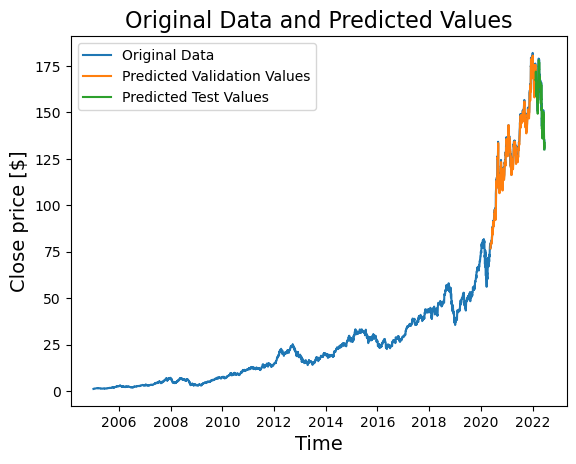

In [90]:
import matplotlib.pyplot as plt
print(df.index)
# Plot the original data and the predicted values
plt.plot(df.index, df['Close'], label='Original Data')
plt.plot(df.index[training_data_len:training_data_len+validation_data_len], Y_val_pred, label='Predicted Validation Values')
plt.plot(df.index[training_data_len+validation_data_len:], Y_test_pred, label='Predicted Test Values')
plt.xlabel('Time', fontdict={'fontsize':14})
plt.ylabel('Close price [$]', fontdict={'fontsize':14})
# plt.xlim(0, 305) to be defined
# plt.ylim(35, 190)
plt.title(f'Original Data and Predicted Values', fontdict={'fontsize':16})
plt.legend()
plt.savefig('LSTM_predictions.png', dpi=900)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


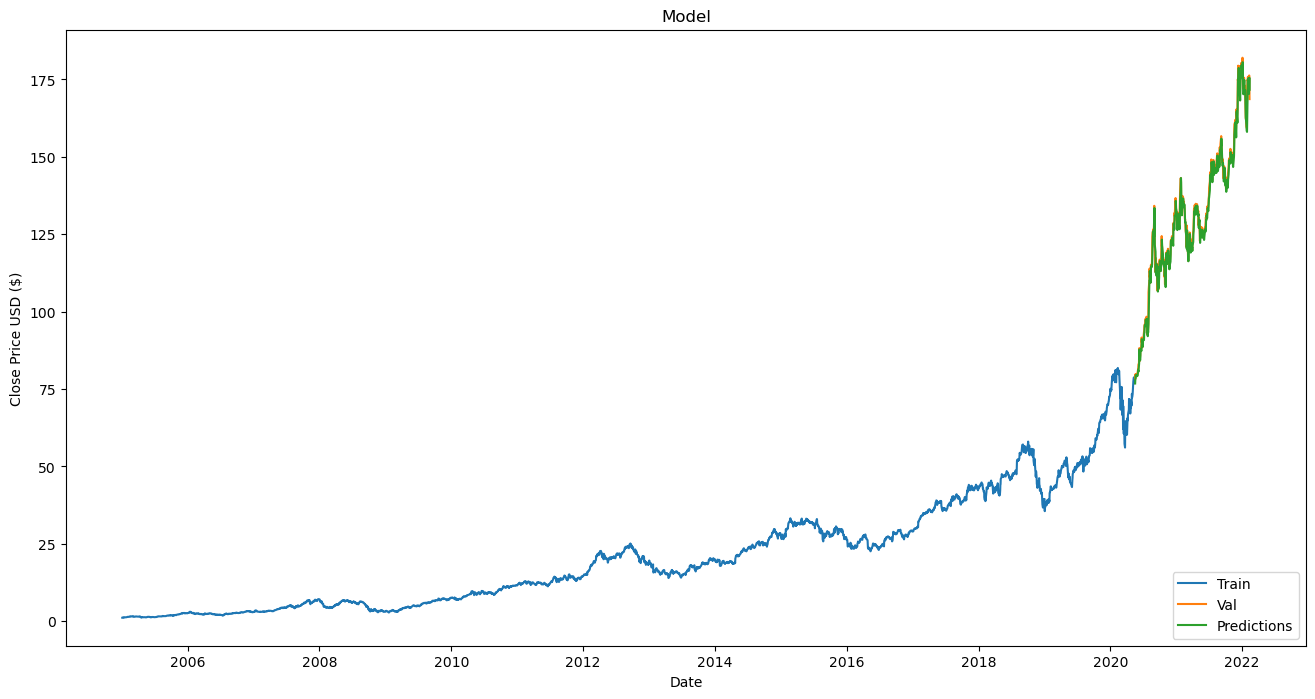

In [88]:
import matplotlib.pyplot as plt

data = df.filter([target])
train = data[:training_data_len]
validation = data[training_data_len:training_data_len+validation_data_len]
validation['Predictions'] = Y_val_pred
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel(target+' Price USD ($)')
plt.plot(train)
plt.plot(validation[[target, 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [89]:
# import plotly.express as px
# fig = px.line(validation.reset_index(), x="Date", y=validation.reset_index().columns[1:], title='Predictions vs Actual')
# fig.show()